In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import ipywidgets as widgets
from IPython.display import display


In [3]:
df = pd.read_csv('dataset/cleaned_us_accident_data.csv')

In [4]:
X_cluster = df[['start_lat', 'start_lng', 'severity']].dropna()

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [6]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


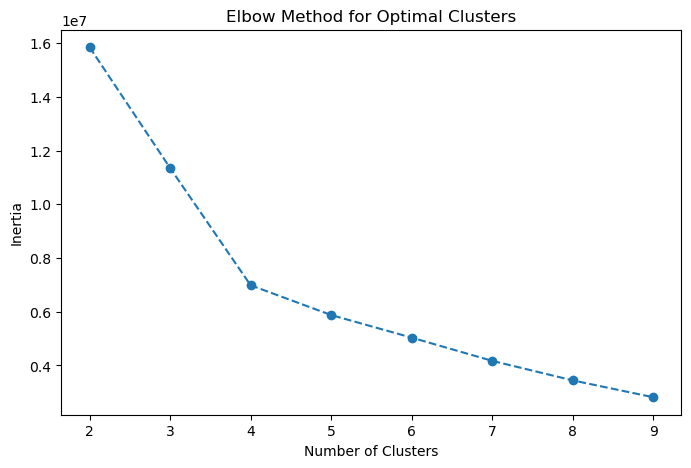

In [7]:
plt.figure(figsize=(8,5))
plt.plot(range(2, 10), inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)
print(df['cluster'].value_counts())

cluster
3    2318578
0    1966571
1    1734607
2    1452528
Name: count, dtype: int64


In [9]:
db_score = davies_bouldin_score(X_scaled, df['cluster'])
print(f"Davies-Bouldin Score: {db_score:.4f}")

Davies-Bouldin Score: 0.7998


In [16]:
def plot_cluster(cluster_num):
    plt.figure(figsize=(10, 6))
    
    if cluster_num == 'All':
        filtered_df = df
        sns.scatterplot(
            data=filtered_df,
            x='start_lng',
            y='start_lat',
            hue='cluster',
            palette='viridis',
            legend='full'
        )
        plt.legend(title='Cluster')
    else:
        filtered_df = df[df['cluster'] == cluster_num]
        sns.scatterplot(
            data=filtered_df,
            x='start_lng',
            y='start_lat',
            color='orange',  # single color for one cluster
            legend=False
        )

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f"High Risk Area Clustering - {cluster_num if cluster_num != 'All' else 'All Clusters'}")
    plt.show()

cluster_options = ['All'] + sorted(df['cluster'].unique().tolist())
cluster_selector = widgets.Dropdown(
    options=cluster_options,
    description='Cluster:'
)

widgets.interact(plot_cluster, cluster_num=cluster_selector)


interactive(children=(Dropdown(description='Cluster:', options=('All', 0, 1, 2, 3), value='All'), Output()), _…

<function __main__.plot_cluster(cluster_num)>

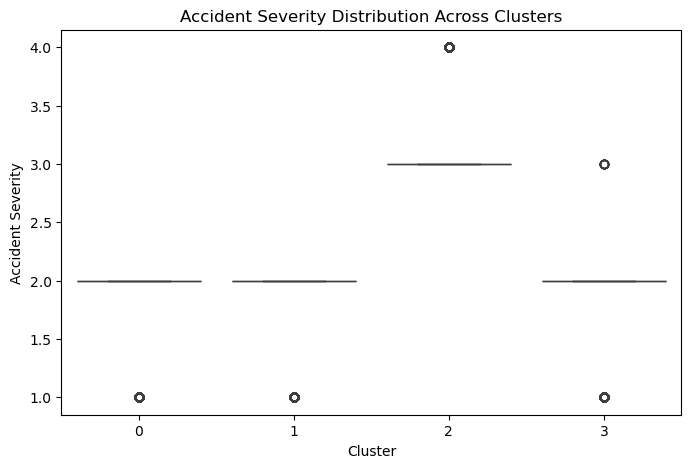

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['cluster'], y=df['severity'])
plt.xlabel('Cluster')
plt.ylabel('Accident Severity')
plt.title('Accident Severity Distribution Across Clusters')
plt.show()


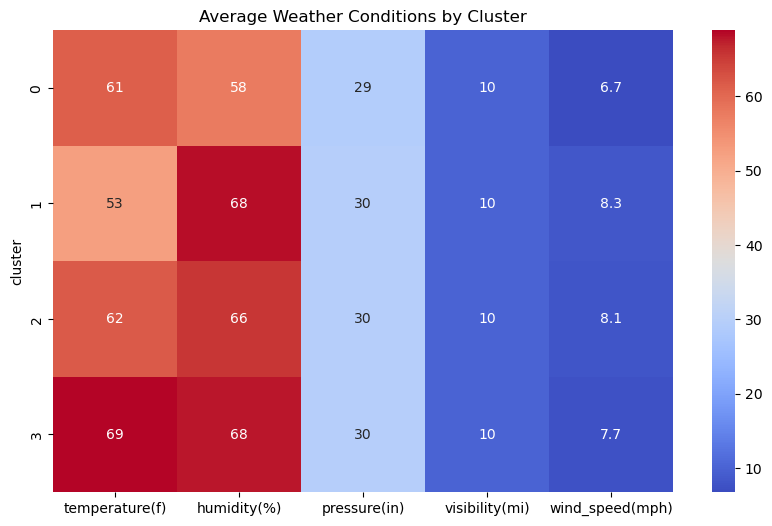

In [12]:
weather_features = ['temperature(f)', 'humidity(%)', 'pressure(in)', 'visibility(mi)', 'wind_speed(mph)']
weather_analysis = df.groupby('cluster')[weather_features].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(weather_analysis, annot=True, cmap="coolwarm")
plt.title('Average Weather Conditions by Cluster')
plt.show()


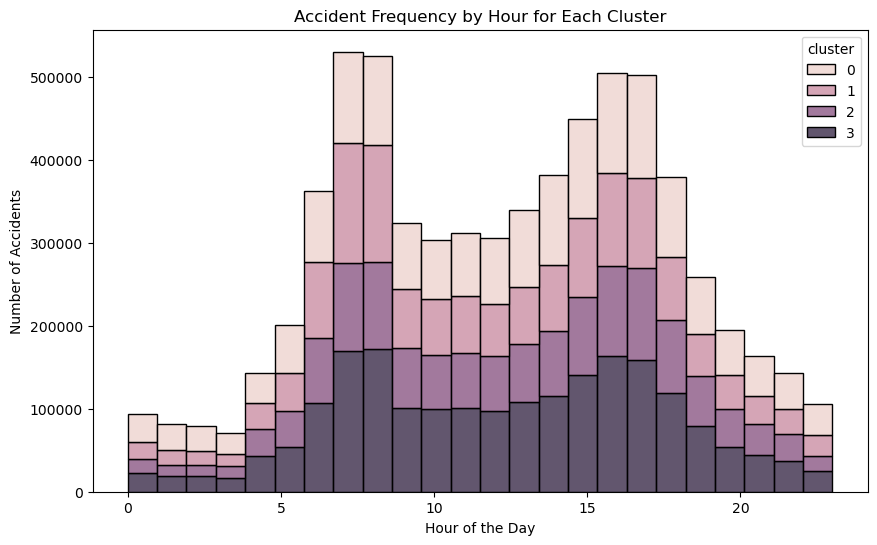

In [13]:
df['hour'] = pd.to_datetime(df['start_time']).dt.hour

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='hour', hue='cluster', multiple='stack', bins=24)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.title('Accident Frequency by Hour for Each Cluster')
plt.show()


In [14]:
top_roads = df.groupby(['cluster', 'street'])['severity'].count().reset_index()
top_roads = top_roads.sort_values(['cluster', 'severity'], ascending=[True, False])

for cluster in df['cluster'].unique():
    print(f"Cluster {cluster} - Top 5 High-Risk Roads:")
    print(top_roads[top_roads['cluster'] == cluster].head(5))
    print("\n")


Cluster 2 - Top 5 High-Risk Roads:
        cluster  street  severity
254301        2  I-95 N     29631
254302        2  I-95 S     27411
253979        2   I-5 N     23547
253537        2  I-10 E     20570
253540        2  I-10 W     20426


Cluster 1 - Top 5 High-Risk Roads:
        cluster  street  severity
168623        1  I-95 N     23035
168624        1  I-95 S     19622
168612        1  I-94 E     14664
168614        1  I-94 W     13793
168600        1  I-90 W     11334


Cluster 0 - Top 5 High-Risk Roads:
       cluster    street  severity
67652        0     I-5 N     46792
67653        0     I-5 S     36784
67565        0    I-10 E     24595
67569        0    I-10 W     22971
90992        0  US-101 N     18696


Cluster 3 - Top 5 High-Risk Roads:
        cluster  street  severity
382527        3  I-95 S     23667
382526        3  I-95 N     21825
382480        3  I-75 N     10078
382521        3    I-95      9939
382482        3  I-75 S      9781


